In [1]:
# %load_ext autoreload
# %autoreload 2

In [ ]:
# Needed if pycharm doesn't include source package in system path
# flag = True
# import sys
# if flag:
#     sys.path.append("..")
#     print(sys.path)
#     flag = False

In [5]:
# Load imports
from river import metrics
from river.utils import Rolling
from river.ensemble import AdaptiveRandomForestClassifier
from river.datasets import ImageSegments
from river import preprocessing
from river import compose
from ixai.explainer import IncrementalPFI, IncrementalSage, IncrementalPDP
from ixai.utils.wrappers import RiverWrapper
from ixai.storage import GeometricReservoirStorage
from ixai.imputer import MarginalImputer

In [6]:
# Set config variables
RANDOM_SEED = 42

In [7]:
# Load stream
stream = ImageSegments()

In [8]:
# Printing an observation from this stream
for n, (x, y) in enumerate(stream):
    print(x)
    print(y)
    feature_names = list(x.keys())
    print(n)
    if n>0:
        break

{'region-centroid-col': 218, 'region-centroid-row': 178, 'short-line-density-5': 0.11111111, 'short-line-density-2': 0.0, 'vedge-mean': 0.8333326999999999, 'vegde-sd': 0.54772234, 'hedge-mean': 1.1111094, 'hedge-sd': 0.5443307, 'intensity-mean': 59.629630000000006, 'rawred-mean': 52.44444300000001, 'rawblue-mean': 75.22222, 'rawgreen-mean': 51.22222, 'exred-mean': -21.555555, 'exblue-mean': 46.77778, 'exgreen-mean': -25.222220999999998, 'value-mean': 75.22222, 'saturation-mean': 0.31899637, 'hue-mean': -2.0405545}
path
0
{'region-centroid-col': 113, 'region-centroid-row': 130, 'short-line-density-5': 0.0, 'short-line-density-2': 0.0, 'vedge-mean': 0.27777776, 'vegde-sd': 0.25092423, 'hedge-mean': 0.33333328, 'hedge-sd': 0.3651483, 'intensity-mean': 0.8888889000000001, 'rawred-mean': 0.0, 'rawblue-mean': 2.5555556, 'rawgreen-mean': 0.11111111, 'exred-mean': -2.6666667, 'exblue-mean': 5.0, 'exgreen-mean': -2.3333333, 'value-mean': 2.5555556, 'saturation-mean': 1.0, 'hue-mean': -2.123254}

In [9]:
# Model and training setup
model = compose.Pipeline(
    preprocessing.StandardScaler()
    | AdaptiveRandomForestClassifier(seed=RANDOM_SEED)
    )

#model = AdaptiveRandomForestRegressor(seed=RANDOM_SEED)

In [10]:
# Use River Wrapper around model function to standardize model outputs, Initialize loss and training metric depending on ML task
model_function = RiverWrapper(model.predict_proba_one)
loss_metric = metrics.CrossEntropy()
training_metric = Rolling(metrics.Accuracy(), window_size=1000)

In [11]:
# Instantiate Storage Object and Imputer
storage = GeometricReservoirStorage(
    size=500,
    store_targets=False
)

imputer = MarginalImputer(
    model_function=model_function,
    storage_object=storage,
    sampling_strategy="joint"
)

In [12]:
# Instantiate Incremental PFI and SAGE Explainers
incremental_pfi = IncrementalPFI(
    model_function=model_function,
    loss_function=loss_metric,
    feature_names=feature_names,
    smoothing_alpha=0.01,
    n_inner_samples=4,
    imputer=imputer,
    storage=storage
)
incremental_sage = IncrementalSage(
    model_function=model_function,
    loss_function=loss_metric,
    imputer=imputer,
    storage=storage,
    feature_names=feature_names,
    smoothing_alpha=0.01,
    n_inner_samples=4
)

In [13]:
# Instantiate Incremental PDP Explainer - mention the column for which PDP plot is required in 'pdp_feature' and since this is a multiclass problem, the label for which feature effects need to be analyzed in 'output_key'
incremental_pdp = IncrementalPDP(
    model_function=model_function,
    gridsize=8,
    dynamic_setting=True,
    smoothing_alpha=0.01,
    pdp_feature='region-centroid-row',
    storage=storage,
    storage_size=100,
    is_classification=True,
    output_key='cement'
)

500: perf 0.714
500: sage  {'hedge-sd': -0.04896130112342596, 'exblue-mean': 0.10965908876591081, 'short-line-density-5': -0.01661099154487009, 'region-centroid-row': 0.22285107605161236, 'value-mean': 0.1376906337522459, 'intensity-mean': 0.13549639309287664, 'rawred-mean': 0.004242654432081681, 'vegde-sd': -0.001014999614023826, 'hue-mean': -0.07896304627034825, 'hedge-mean': 0.05406578023288631, 'exred-mean': 0.07321325177063462, 'short-line-density-2': 0.07935435181882032, 'rawgreen-mean': 0.45696487979254186, 'saturation-mean': -0.11138621609323171, 'region-centroid-col': -0.15297959607134404, 'exgreen-mean': 0.10757908048469328, 'rawblue-mean': 0.10548137337387901, 'vedge-mean': 0.10654531824921473}
500: pfi  {'hedge-sd': 0.00011502010652186963, 'exblue-mean': 0.048164922730816996, 'short-line-density-5': -0.0007643876978712705, 'region-centroid-row': 0.18588769910037528, 'intensity-mean': 0.17130451802609747, 'vegde-sd': 0.007060403458892896, 'rawred-mean': 0.013358129612259363,

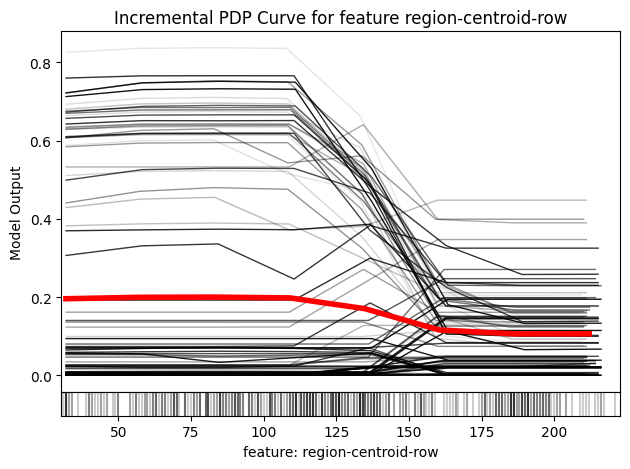

In [14]:
# Iterate over stream and explain each instance using explainers
for (n, (x_i, y_i)) in enumerate(stream, start=1):
    x_i = dict((k, x_i[k]) for k in feature_names)
    y_i_pred = model.predict_one(x_i)
    #print(y_i_pred)
    training_metric.update(y_true=y_i, y_pred=y_i_pred)

    # explaining
    inc_sage = incremental_sage.explain_one(x_i, y_i)
    inc_fi_pfi = incremental_pfi.explain_one(x_i, y_i, update_storage=False)
    inc_pdp = incremental_pdp.explain_one(x_i, update_storage=False)

    # learning
    model.learn_one(x_i, y_i)
    #print("Here")
    if n % 500 == 0:
        print(f"{n}: perf {training_metric.get()}\n"
              f"{n}: sage  {incremental_sage.importance_values}\n"
              f"{n}: pfi  {incremental_pfi.importance_values}\n")

    if n >= 2000:
        incremental_pdp.plot_pdp()
        break